In [1]:
from cci import *
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from copy import *
from math import *
import pylab

In [142]:
T_cmb = 2.725
pfc = {
"omega_b":0.02226,
"omega_cdm": 0.1193,
"h" : 0.6751,
"tau_reio" : 0.063, 
"n_s" :  0.9653,
"A_s" :  2.13e-9 
}

best_fit ={
"omega_b": 0.0221693,
"omega_cdm": 0.121012,
"h" : 0.661266,
"tau_reio" : 0.071823,
"n_s" :  0.961953,
"ln10^{10}A_s" :  3.07599,
"A_planck":   0.998698,

"N_eff" : 1.046,
"N_ncdm" : 2,
"m_ncdm ": [0.08, 0.08],
"sig_ncdm" : [0.500989,0.500989]
    
}

pfc_ncdm ={"omega_b":0.02226,
"omega_cdm": 0.1193,
"h" : 0.6751,
"tau_reio" : 0.063, 
"n_s" :  0.9653,
"A_s" :  2.13e-9,
"N_eff" : 1.046,
"N_ncdm" : 2,
"m_ncdm ": [0.08, 0.08],
"sig_ncdm" : [0.5,0.5]
}



In [3]:
planck = run_class(pfc)
inter = run_class(pfc_ncdm)

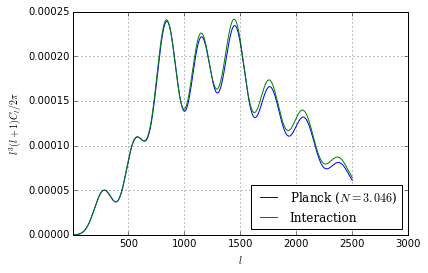

In [4]:
pylab.plot(planck[:,0],np.multiply(planck[:,0],np.multiply(planck[:,0],planck[:,1])),label = "Planck ($N=3.046$)")
pylab.plot(inter[:,0],np.multiply(inter[:,0],np.multiply(inter[:,0],inter[:,1])),label = "Interaction")



#pylab.loglog(noint[:,0],cl_original,label = "Planck (original code)")

#pylab.loglog(one_int[:,0],cl_one_int,label = "Planck + $N_{\text{eff}}=1.0$ + int")
#pylab.loglog(one_noint[:,0],cl_one_noint,label = r"($a^4 G^m = 1 \times 10^{-22}$), lmax = 10")

plt.rc('font', family='serif')
pylab.legend(loc=4)
plt.xlim((10,3000))
#plt.ylim((5*10**-11,5*10**-9))
pylab.grid()
pylab.xlabel("$l$")
pylab.ylabel("$l^3(l+1)C_l/2\pi$")# in $[\mu k]^2$")
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [135]:
def dC_dx(params, x, c_l, p_change=0.001):
    if x not in params:
        raise NameError(x+ " not in parameter list.")
    temp_params = deepcopy(params)
    #c_l = run_class(temp_params) commented out since it will be faster to just calculate this once
    if isinstance(params[x],list):
        temp_params[x]= [i*(1+p_change) for i in params[x]]
        dx = i*(p_change)
    else:
        temp_params[x]= params[x]*(1+p_change)
        dx = params[x]*(p_change)
    c_lp = run_class(temp_params)
    return np.hstack([np.array([c_lp[:,0]]).T,np.divide(c_lp[:,1:]-c_l[:,1:],dx)])

In [136]:
#Planck Values: http://arxiv.org/pdf/astro-ph/0310198v3.pdf
f_sky = 0.65#80
weight = 40*10**(-9)/T_cmb #unitless, for P bands: 56
beamsize = 7 #in degrees(?)
def delta_Cl(l,C_l,f_sky=f_sky,b=beamsize,w=weight):
    B = np.exp(l*(l+1)*b**2/(8*log(2)))
    dC = 2/(f_sky*(2*l+1))*((C_l + w**2*B**(-2))**2)
    return dC

In [137]:
def simple_fisher(params,params_var = [0], p_change = 0.00005):
    size = len(params_var)
    if params_var == [0]:
        params_var = params
        size = len(params.keys())
    C=run_class(params)
    F = np.zeros([size,size])
    for i1,j1 in enumerate(params_var):
        for i2,j2 in enumerate(params_var):
            sum_ol = 0
            print j1, j2
            V1 = dC_dx(params,j1,C,p_change = p_change)
            V2 = dC_dx(params,j2,C,p_change = p_change)
            for l,X in enumerate(C):
                V_deltaC = 1/delta_Cl(X[0],X[1])
                #print X[0],V_deltaC, V1[l][1],V2[l][1]
                sum_ol = sum_ol + V1[l][1]*V2[l][1]*V_deltaC
            print sum_ol
            F[i1,i2]=sum_ol
    return F

In [138]:
F_pfc = simple_fisher(pfc)

A_s A_s


/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


4.48075563822e+23
A_s h
-9.14403037033e+14
A_s tau_reio
-4.4417755021e+15
A_s n_s
8.77922277127e+14
A_s omega_b
1.30352864639e+16
A_s omega_cdm
-3.91620886763e+15
h A_s
-9.14403037033e+14
h h
5039719.36041
h tau_reio
9095278.85547
h n_s
-2152974.1691
h omega_b
-63933521.1925
h omega_cdm
19636605.7958
tau_reio A_s
-4.4417755021e+15
tau_reio h


NameError: Error in class, check class.log file

In [77]:
#Unmarganilized Values (Very small!)
for i,_ in enumerate(F_pfc):
    print pfc.keys()[i], 2/sqrt(F_pfc[i,i])

A_s 2.98781955733e-12
h 0.000890895610349
tau_reio 0.000301165906509
n_s 0.00136796055867
omega_b 5.68908082356e-05
omega_cdm 0.000225278375144


In [22]:
pfc.keys()

['A_s', 'h', 'tau_reio', 'n_s', 'omega_b', 'omega_cdm']

In [90]:
inverse = np.linalg.inv(F_pfc)

In [134]:
# Marganilized Errors; compare well with that on page 31 of 1502.01589v2 (TT + lowP)
inverse = np.linalg.inv(F_pfc)
for i,_ in enumerate(F_pfc):
    print pfc.keys()[i], 2*sqrt(inverse[i,i])

A_s 1.61734238038e-06
h 187.874457209
tau_reio 162.338669152
n_s 107.162398858
omega_b 2.7469589097
omega_cdm 46.2442666899


In [139]:
params_var = ["A_s",
 'n_s',
 'omega_b',
 'omega_cdm',
 'h',
 'tau_reio',
    'sig_ncdm']

In [143]:
F_ncdm = simple_fisher(pfc_ncdm,params_var=params_var)

A_s A_s


/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: overflow encountered in exp


4.48075563592e+23
A_s n_s
8.81894722696e+14
A_s omega_b
1.25090835812e+16
A_s omega_cdm
-3.78094808779e+15
A_s h
-8.88689696693e+14
A_s tau_reio
-4.50994182693e+15
A_s sig_ncdm
-4.70669894015e+13
n_s A_s
8.81894722696e+14
n_s n_s
2153402.89279
n_s omega_b
35926124.5496
n_s omega_cdm
-7879223.22888
n_s h
-2088975.53119
n_s tau_reio
-8988553.35696
n_s sig_ncdm
-105808.755838
omega_b A_s
1.25090835812e+16
omega_b n_s
35926124.5496
omega_b omega_b
1122262026.95
omega_b omega_cdm
-229983113.393
omega_b h
-63553442.4931
omega_b tau_reio
-131964514.119
omega_b sig_ncdm
-2096215.85785
omega_cdm A_s
-3.78094808779e+15
omega_cdm n_s
-7879223.22888
omega_cdm omega_b
-229983113.393
omega_cdm omega_cdm
75520993.3236
omega_cdm h
19022407.6434
omega_cdm tau_reio
38568775.456
omega_cdm sig_ncdm
587971.303543
h A_s
-8.88689696693e+14
h n_s
-2088975.53119
h omega_b
-63553442.4931
h omega_cdm
19022407.6434
h h
4992631.22991
h tau_reio
9092178.86887
h sig_ncdm
140504.194783
tau_reio A_s
-4.50994182693e+15

In [144]:
inverse = np.linalg.inv(F_ncdm)
for i,_ in enumerate(F_ncdm):
    print params_var[i], 2*sqrt(inverse[i,i])

A_s 7.52666004597e-11
n_s 0.00723886017184
omega_b 0.000189033481024
omega_cdm 0.00272207529525
h 0.0109053802542
tau_reio 0.0082442206093
sig_ncdm 0.0181644825478


In [116]:
F_ncdm = F_ncdm[0:6,0:6]